# Initialization

In [20]:
import pandas as pd
import numpy as np
import os
import datetime
from enum import Enum
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import joblib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.neural_network import MLPClassifier # Unsupervised
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, RocCurveDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# import tensorflow_decision_forests as tfdf


In [21]:
#Categorize and enumerate all attacks in dataset
ATTACKS = ['DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Benign', 'Web', 'BruteForce']
ATTACKS_ENUM = Enum('ATTACKS', ATTACKS, start=0)
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [ ]:
# ===== Generation of CSV data =====
# Adapted from same source as Dataset
run_this = False
if(run_this):
    from pcap2csv import Generating_dataset #Generating_dataset#, Supporting_functions, Communication_features, Connectivity_features, Dynamic_features, Feature_extraction, Layered_features
    import os
    PCAP_DIRECTORY = 'pcap/'
    pcap_files = [k for k in os.listdir(PCAP_DIRECTORY) if k.endswith('.pcap')] 
    Generating_dataset.make_csv(pcap_files)


In [34]:
# =====Split Train / Test data======
# Dataset link-> https://www.unb.ca/cic/datasets/iotdataset-2023.html
#E. C. P. Neto, S. Dadkhah, R. Ferreira, A. Zohourian, R. Lu, A. A. Ghorbani. "CICIoT2023: A real-time dataset and benchmark for large-scale attacks in IoT environment," Sensor (2023) – (submitted to Journal of Sensors).

DATASET_DIRECTORY = 'dataset/'
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if (k.endswith('.csv') and not k.endswith('encrypted.csv'))] # all files
#df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('1-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')] # smaller subset for faster testing, 17 files =  10% of whole dataset
# df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('11-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')] # 2 files = 1%
df_sets.sort()
training_sets = df_sets[:int(len(df_sets)*.8)]
test_sets = df_sets[int(len(df_sets)*.8):]

In [23]:
#=====Extract Data=====

# === PerFlow ===
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
] #columns 0-45

# === PerPacket ===
# X_columns = [
#     'Header_Length', 'Protocol Type', 'Duration',
#         'fin_flag_number', 'syn_flag_number',
#        'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
#        'ece_flag_number', 'cwr_flag_number', 
#     'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
#        'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
# ] #columns 0-45



Y_columns = 'label' #column 46

all_columns = X_columns+[Y_columns]

NUMERIC_FEATURE_NAMES = [
      'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
      'Rate', 'Srate', 'Drate', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 
      'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
      'Radius', 'Covariance', 'Variance', 'Weight', 
]
CATEGORICAL_FEATURE_NAMES = [
      'fin_flag_number', 'syn_flag_number',
      'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
      'ece_flag_number', 'cwr_flag_number','HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
      'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
]


In [27]:
#=====Feature Scaling======
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(-1,1)) # for SVC
for train_set in tqdm(training_sets):
    df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[X_columns]
    scaler.fit(df)
    del df

100%|██████████| 135/135 [02:13<00:00,  1.01it/s]


# Define Model layers

In [28]:
class Model:
    def __init__(self, model, name, type, callbacks=None):
        self.model = model
        self.name = name
        self.type = type
        self.callbacks = callbacks
        #self.batch_size = batch_size

TYPES = {}
TYPES['SK_LR'] = 1
TYPES['SK_RF'] = 2
TYPES['SK_SVC'] = 3
TYPES['TF'] = 4
TYPES['TF_RNN'] = 5
TYPES['TF_CNN'] = 6

verbose, epochs, batch_size = 0, 10, 64
activationFunction='relu'

numFeatures=len(X_columns)
numClasses=len(ATTACKS)

# def getOtimizedSequentialModel():
#     model = Sequential()
#     model.add(Dense(46, activation=activationFunction))
#     model.add(Dense(30, activation=activationFunction))
#     model.add(Dense(8, activation='softmax'))
#     model.compile(loss=keras.losses.BinaryCrossentropy(),
#                     optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
#                     metrics=[ keras.metrics.BinaryAccuracy(), keras.metrics.FalseNegatives()]
#                     )
#     return model

# def getANN():
#     model = Sequential()
#     model.add(Dense(46, activation=activationFunction))
#     model.add(Dense(30, activation=activationFunction))
#     model.add(Dense(20, activation=activationFunction))
#     model.add(Dense(12, activation=activationFunction))
#     model.add(Dense(numClasses, activation='softmax'))
#     model.compile(loss=keras.losses.BinaryCrossentropy(),
#                     optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
#                     metrics=[ keras.metrics.BinaryAccuracy(), keras.metrics.FalseNegatives()]
#                     )
#     return Model(model, "ANN", TYPES['TF'])

def getANN():
    model = Sequential()
    model.add(Dense(128, input_dim=numFeatures, activation=activationFunction))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation=activationFunction))
    model.add(Dense(32, activation=activationFunction))
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                    metrics=[ keras.metrics.BinaryAccuracy()]
                    )
    return Model(model, "ANN2", TYPES['TF'])

# def getANN3():
#     model = Sequential()
#     model.add(Dense(128, input_dim=numFeatures, activation=activationFunction))
#     model.add(Dropout(0.2))
#     model.add(Dense(64, activation=activationFunction))
#     model.add(Dense(32, activation=activationFunction))
#     model.add(Dense(16, activation=activationFunction))
#     model.add(Dense(numClasses, activation='softmax'))
#     model.compile(loss='categorical_crossentropy',
#                     optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
#                     metrics=[ keras.metrics.BinaryAccuracy()]
#                     )
#     return Model(model, "ANN3", TYPES['TF'])

def getRNN():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return Model(model, "RNN", TYPES['TF_RNN'])

def getCNN():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(numFeatures, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return Model(model, 'CNN', TYPES['TF_CNN'])

# def getCNN2():
#     model = Sequential()
#     model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(numFeatures, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
#     model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(Dropout(0.5))
#     model.add(Dense(numClasses, activation='softmax'))
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     return Model(model, 'CNN', TYPES['TF_CNN'], [early_stopping])

def getRFModel():
    rf = RandomForestClassifier(
        n_estimators=100,
        criterion = 'gini',
        max_depth=None,
        )
    return Model(rf, "RF", TYPES['SK_RF'])

def getDTModel():
    rf = DecisionTreeClassifier(
        criterion = 'gini',
        max_depth=None,
        )
    return Model(rf, "DT", TYPES['SK_RF'])

def getLRModel():
    lr = LogisticRegression()
    return Model(lr, "LR", TYPES['SK_LR'])

def getSVCModel():
    model = SVC()
    return Model(model, "SVCovr", TYPES['SK_SVC'])

def getovoSVCModel():
    model = SVC(decision_function_shape='ovo', verbose=False, cache_size=1000)
    return Model(model, "SVCovo", TYPES['SK_SVC'])

def getLinSVCModel():
    model = LinearSVC(tol = 1e-5)
    return Model(model, "Lin-SVC", TYPES['SK_LR'])

def getSGDCModel():
    return Model(SGDClassifier(loss='log_loss', penalty='l1', alpha=1e-8, max_iter=3000, tol=1e-5, random_state=11), "SGDC", TYPES['SK_LR'])

def getKNNCModel():
    model = KNeighborsClassifier() # default 5 neighbors
    return Model(model, "KNNC", TYPES['SK_LR'])

def getRadNNCModel():
    model = RadiusNeighborsClassifier()
    return Model(model, "RadNNC", TYPES['SK_LR'])

def getNCentModel():
    model = NearestCentroid()
    return Model(model, "NCent", TYPES['SK_LR'])

def getRidgeModel():
    model = RidgeClassifier(solver='saga')
    return Model(model, "Ridge", TYPES['SK_RF'])

def getBNBModel():
    model = BernoulliNB()
    return Model(model, "Bernoulli Naive Bayes", TYPES['SK_LR'])

def getCNBModel():
    model = CategoricalNB()
    return Model(model, "Categorical Naive Bayes", TYPES['SK_LR'])

def getGNBModel():
    model = GaussianNB()
    return Model(model, "Gausian Naive Bayes", TYPES['SK_LR'])

def getMLPCModel():
    model = MLPClassifier() #MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)  
    return Model(model, "MLPC", TYPES['SK_LR'])

def getNUSVCModel():
    model = NuSVC()
    return Model(model, "NuSVC", TYPES['SK_LR'])

mod1 = getANN()
mod1.name="ANN1"
mod2 = getKNNCModel()
mod2.name="KNNC3"
mod3 = getCNN()
mod3.name="CNN3"
mod4 = getRNN()
mod4.name="RNN"
mod5 = getSGDCModel()
mod5.name="SGDC"
ML_Models = [
            mod1
            # mod1,
            # mod2,
            # mod3,
            # mod4,
            # mod5
]

# Train Models

In [ ]:
print(f"Last ran on {len(ML_Models)} models, with {len(training_sets)} training sets on date: {datetime.datetime.now()}")
for train_set in tqdm(training_sets[:1]):
    df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[all_columns]
    x_train = scaler.transform(df[X_columns])
    y_train = [ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns]]
    y_train_Cat = to_categorical(y_train, num_classes=numClasses)

    for i in range(len(ML_Models)):
            # print(f"model{i}")
            model = ML_Models[i]
            if model.type==TYPES["SK_LR"]:
                model.model.fit(x_train, y_train)  
            
            if model.type==TYPES["SK_SVC"]:
                length = len(x_train) 
                print(length)
                slicesize = length//8
                for j in range(0, length, slicesize):
                    curr_x_train = x_train[j:j+slicesize]
                    curr_y_train = y_train[j:j+slicesize]
                    print(f"training on {j}")
                    model.model.fit(curr_x_train, curr_y_train)
                del curr_x_train

            elif model.type==TYPES["SK_RF"]:
                model.model.fit(x_train, y_train_Cat)  

            elif model.type == TYPES["TF"]:
                model.model.fit(x=x_train, 
                            y=y_train_Cat, 
                            epochs=epochs, 
                            verbose=verbose,
                            batch_size=batch_size) 

            elif model.type == TYPES['TF_RNN']: 
                curr_x_train= np.reshape(x_train, (x_train.shape[0], 1, numFeatures))
                model.model.fit(x=curr_x_train, 
                            y=y_train_Cat, 
                            epochs=epochs, 
                            verbose=verbose,
                            batch_size=batch_size) 
                del curr_x_train

            elif model.type == TYPES['TF_CNN']: 
                curr_x_train= np.reshape(x_train, (x_train.shape[0], numFeatures, 1))
                model.model.fit(x=curr_x_train, 
                            y=y_train_Cat, 
                            epochs=epochs, 
                            verbose=verbose,
                            batch_size=batch_size,
                            callbacks=model.callbacks
                            )    
                del curr_x_train         
    del df
    del x_train
    del y_train
    del y_train_Cat



# Test the resulting trained models

In [43]:
def showResults(test, pred,model_name, encrypted=False):
    output = ''
    output += str(datetime.datetime.now())
    output += f"\n===== {model_name} =====\n"
    if not encrypted:
        output+=classification_report(test, pred, target_names=ATTACKS)
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    recall = recall_score(test, pred, average="weighted")
    output+=f"\nAccuracy  : {accuracy}\n"
    output+=f"Precision : {precision}\n"
    output += f"Recall : {recall}\n"
    output+=f"f1Score : {f1Score}\n"
    cm=confusion_matrix(test, pred)
    output+=str(cm) 
    
    if encrypted:
        joblib.dump(output, f"outputs/{model_name}-encrypted.txt", protocol=1) 
    else:
        joblib.dump(output, f"outputs/{model_name}.txt", protocol=1) 

    print(output)


In [61]:
def getRecall(model):
    y_test = []
    y_predict = []
    for test_set in tqdm(test_sets):
        df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
        x_test = scaler.transform(df[X_columns])
        for k in df[Y_columns]:
            y_test.append(ATTACKS_ENUM[dict_7classes[k]].value)
        if model.type == TYPES['TF'] or model.type==TYPES['TF_CNN']:
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type== TYPES["TF_RNN"]:
            x_test= np.reshape(x_test, (x_test.shape[0], 1, numFeatures))
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type==TYPES["SK_SVC"]:
            length = len(x_test) 
            print(length)
            slicesize = length//8
            for j in range(0, length, slicesize):
                curr_x_test = x_test[j:j+slicesize]
                print(f"testing on {j}")
                y_predict+= list(model.model.predict(curr_x_test))
        else:
            y_predict+= list(model.model.predict(x_test))

        del df
        del x_test

    y_test=np.array(y_test)
    if model.type == TYPES['TF'] or model.type ==TYPES["SK_RF"] or model.type==TYPES["TF_RNN"] or model.type==TYPES['TF_CNN']:
        y_test = to_categorical(y_test, num_classes=8)
        y_test = np.argmax(y_test, axis=1)
        y_predict = np.argmax(y_predict, axis=1)
    
    return recall_score(y_test, y_predict, average="weighted")


folder = 'SavedModels/PerFlow/'
Models = ["ANN1.keras","ANN2.keras","ANN3.keras", "RNN.pkl", 'CNN1.pkl','CNN2.pkl', 'CNN3.pkl', 'DT.pkl', "RF1.pkl", "RF2.pkl","RF3.pkl", "KNNC1.pkl", "KNNC2.pkl","KNNC3.pkl", "Lin-SVC.pkl","LR.pkl","SGDC.pkl"]
ModelTypes = ["TF", "TF", "TF", "TF_RNN", 'TF_CNN','TF_CNN','TF_CNN', 'SK_RF', "SK_RF","SK_RF","SK_RF", "SK_LR", "SK_LR", "SK_LR", "SK_LR","SK_LR","SK_LR"]

for i in range(len(Models)):
    model_name = Models[i].split('.')
    if model_name[1] == 'pkl':
        model = Model(joblib.load(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    elif model_name[1] == 'keras':
        model = Model(load_model(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    else:
        print(f'Error occured at {i} model {Models[i]} type {ModelTypes[i]} : {model_name[0]} - {model.name[1]}')

    print(f"{model.name}, {getRecall(model)}")



100%|██████████| 34/34 [05:30<00:00,  9.73s/it]


ANN1, 0.8980204466835671


100%|██████████| 34/34 [05:15<00:00,  9.27s/it]


ANN2, 0.9897758845340996


100%|██████████| 34/34 [06:16<00:00, 11.08s/it]


ANN3, 0.9901803269794348


100%|██████████| 34/34 [10:21<00:00, 18.29s/it]


RNN, 0.9919436457517441


100%|██████████| 34/34 [14:30<00:00, 25.61s/it]


CNN1, 0.9587012233175093


100%|██████████| 34/34 [14:13<00:00, 25.11s/it]


CNN2, 0.9582944598251419


100%|██████████| 34/34 [12:52<00:00, 22.73s/it]


CNN3, 0.9828162250084888


100%|██████████| 34/34 [01:12<00:00,  2.15s/it]


DT, 0.9938437128783585


100%|██████████| 34/34 [04:41<00:00,  8.27s/it]


RF1, 0.991719374582272


100%|██████████| 34/34 [04:04<00:00,  7.20s/it]


RF2, 0.9918904550905929


100%|██████████| 34/34 [04:04<00:00,  7.20s/it]


RF3, 0.9919651154367906


100%|██████████| 34/34 [58:14<00:00, 102.76s/it] 


KNNC1, 0.9470609790311776


100%|██████████| 34/34 [48:57<00:00, 86.41s/it]  


KNNC2, 0.9470609790311776


100%|██████████| 34/34 [48:59<00:00, 86.45s/it] 


KNNC3, 0.9470609790311776


100%|██████████| 34/34 [01:28<00:00,  2.62s/it]


Lin-SVC, 0.8251153923038529


100%|██████████| 34/34 [01:13<00:00,  2.17s/it]


LR, 0.8316742843752626


100%|██████████| 34/34 [01:08<00:00,  2.01s/it]


SGDC, 0.8464756012986645


In [70]:
def testModel(model, encrypted=False):
    y_test = []
    y_predict = []
    for test_set in tqdm(test_sets):
        df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
        x_test = scaler.transform(df[X_columns])
        for k in df[Y_columns]:
            if not encrypted:
                y_test.append(ATTACKS_ENUM[dict_7classes[k]].value)
            else:
                y_test.append(k=="Benign")
                # if(k=="Benign"):
                #     y_test.append(1)
                # else:
                #     y_test.append(0)
        if model.type == TYPES['TF'] or model.type==TYPES['TF_CNN']:
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type== TYPES["TF_RNN"]:
            x_test= np.reshape(x_test, (x_test.shape[0], 1, numFeatures))
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type==TYPES["SK_SVC"]:
            length = len(x_test) 
            print(length)
            slicesize = length//8
            for j in range(0, length, slicesize):
                curr_x_test = x_test[j:j+slicesize]
                print(f"testing on {j}")
                y_predict+= list(model.model.predict(curr_x_test))
        else:
            y_predict+= list(model.model.predict(x_test))

        del df
        del x_test

    y_test=np.array(y_test)
    if model.type == TYPES['TF'] or model.type ==TYPES["SK_RF"] or model.type==TYPES["TF_RNN"] or model.type==TYPES['TF_CNN']:
        y_test = to_categorical(y_test, num_classes=8)
        y_test = np.argmax(y_test, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

    if encrypted:
        for i in range(len(y_predict)):
            y_predict[i] = (y_predict[i]==ATTACKS_ENUM["Benign"].value)
        # print(f"pred shape: {np.array(y_predict).shape}")
        # print(y_test)
        # print(f"test shape: {y_test.shape}")
        print("test set:")
        print(f"{min(y_test)}, {max(y_test)}")
        print("pred set:")
        print(f"{min(y_predict)}, {max(y_predict)}")
    showResults(y_test, y_predict, model.name, encrypted=encrypted)


    del y_test
    del y_predict

In [8]:
# for timing, remove file i/o times
def onlyPredict(model):
    y_test = []
    y_predict = []
    for test_set in tqdm(test_sets):
        df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
        x_test = scaler.transform(df[X_columns])
        for k in df[Y_columns]:
            y_test.append(ATTACKS_ENUM[dict_7classes[k]].value)
        if model.type == TYPES['TF'] or model.type==TYPES['TF_CNN']:
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type== TYPES["TF_RNN"]:
            x_test= np.reshape(x_test, (x_test.shape[0], 1, numFeatures))
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type==TYPES["SK_SVC"]:
            length = len(x_test) 
            print(length)
            slicesize = length//8
            for j in range(0, length, slicesize):
                curr_x_test = x_test[j:j+slicesize]
                print(f"testing on {j}")
                y_predict+= list(model.model.predict(curr_x_test))
        else:
            y_predict+= list(model.model.predict(x_test))

        del df
        del x_test

    y_test=np.array(y_test)
    if model.type == TYPES['TF'] or model.type ==TYPES["SK_RF"] or model.type==TYPES["TF_RNN"] or model.type==TYPES['TF_CNN']:
        y_test = to_categorical(y_test, num_classes=8)
        y_test = np.argmax(y_test, axis=1)
        y_predict = np.argmax(y_predict, axis=1)


    del y_test
    del y_predict

In [10]:
# for graphing model
# def getBinary(test, pred):
#     return test != ATTACKS_ENUM[dict_7classes["BenignTraffic"]].value, pred != ATTACKS_ENUM[dict_7classes["BenignTraffic"]].value
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
def getROC(model):
    y_test = []
    y_predict = []
    for test_set in tqdm(test_sets):
        df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
        x_test = scaler.transform(df[X_columns])
        for k in df[Y_columns]:
            y_test.append(ATTACKS_ENUM[dict_7classes[k]].value)
        if model.type == TYPES['TF'] or model.type==TYPES['TF_CNN']:
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type== TYPES["TF_RNN"]:
            x_test= np.reshape(x_test, (x_test.shape[0], 1, numFeatures))
            y_predict+= list(model.model.predict(x_test, verbose=0))
        elif model.type==TYPES["SK_SVC"]:
            length = len(x_test) 
            print(length)
            slicesize = length//8
            for j in range(0, length, slicesize):
                curr_x_test = x_test[j:j+slicesize]
                print(f"testing on {j}")
                y_predict+= list(model.model.decision_function(curr_x_test))
        elif(model.name=="Lin-SVC"):
            y_predict+= list(model.model.decision_function(x_test))
        elif(model.type == TYPES["SK_RF"]):
            # DT and RF were trained a bit differently, so they can only predict with 100% certainty for now
            y_predict += list(model.model.predict(x_test))
        else:
            y_predict+= list(model.model.predict_proba(x_test))
        # return
        del df
        del x_test
    
    # SGD outputs NaN sometimes for predict_proba because it does prob/=prob.sum(...) = 0/0
    # known error, couldn't find fix
    # https://github.com/scikit-learn/scikit-learn/pull/18015
    # So I'm deleting NaN datapoints instead of fixing root issue
    if(model.name[:4]=="SGDC"):
        new_y_pred = []
        new_y_test = []
        for i in range(len(y_predict)):
            if not np.isnan(np.sum(y_predict[i])):

                new_y_pred+=list(y_predict[i])
                new_y_test.append(y_test[i])
        y_predict=new_y_pred
        y_test=new_y_test
    y_predict = np.array(y_predict)
    y_test=np.array(y_test)
    label_binarizer.fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    
    return y_onehot_test, y_predict


    

In [ ]:
for i in range(len(ML_Models)):
    model = ML_Models[i]
    if model.type==TYPES["TF"]:# or model.type==TYPES['TF_CNN'] or model.type==TYPES['TF_RNN']:
        model.model.save(f"SavedModels\\{model.name}.keras",overwrite=True)
    else:
        joblib.dump(model.model, f"SavedModels/{model.name}.pkl") 

In [ ]:
print(f"Last ran on {len(ML_Models)} models, with {len(test_sets)} testing sets on date: {datetime.datetime.now()}")
# temp_df_sets=[k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
# test_sets=temp_df_sets[int(len(temp_df_sets)*.8):]
for i in range(len(ML_Models)):
    testModel(ML_Models[i])

In [ ]:
from time import process_time_ns

# test_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')] 
folder = 'SavedModels/PerFlow/'
Models = ["ANN1.keras", "RNN.pkl", 'CNN1.pkl', 'DT.pkl', "RF1.pkl", "KNNC1.pkl", "Lin-SVC.pkl","LR.pkl","SGDC.pkl"] # also test RF from modelTooBig
ModelTypes = ["TF", "TF_RNN", 'TF_CNN', 'SK_RF', "SK_RF", "SK_LR", "SK_LR","SK_LR","SK_LR"]
#Models = ["LR.pkl"]
#ModelTypes = ["SK_LR"]

# === TIMING ===
test_sets = test_sets[:1] # only for timing, remove for graphing
df = pd.read_csv(DATASET_DIRECTORY + test_sets[0], index_col=None, header=0, delimiter=',')[all_columns]
x_test = scaler.transform(df[X_columns])
y_test = (ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns])
predictions = len(df)
output = f'for {predictions} predictions:\n'

for i in range(len(Models)):
    model_name = Models[i].split('.')
    if model_name[1] == 'pkl':
        model = Model(joblib.load(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    elif model_name[1] == 'keras':
        model = Model(load_model(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    else:
        print(f'Error occured at {i} model {Models[i]} type {ModelTypes[i]} : {model_name[0]} - {model.name[1]}')
        raise Exception 
    curr_time = process_time_ns()
    onlyPredict(model) 
    timeTaken = process_time_ns() - curr_time
    output += f"Model {Models[i]} took {timeTaken} ns = {timeTaken/predictions} ns/pred\n"
joblib.dump(output, f"outputs/PerPacketTimes.txt", protocol=1) 


ANN1


100%|██████████| 34/34 [05:26<00:00,  9.60s/it]


RNN


100%|██████████| 34/34 [08:05<00:00, 14.29s/it]


CNN1


100%|██████████| 34/34 [10:24<00:00, 18.38s/it]


DT


100%|██████████| 34/34 [01:02<00:00,  1.83s/it]


RF1


100%|██████████| 34/34 [05:36<00:00,  9.90s/it]


KNNC1


100%|██████████| 34/34 [40:46<00:00, 71.95s/it]


Lin-SVC


100%|██████████| 34/34 [01:00<00:00,  1.79s/it]


LR


100%|██████████| 34/34 [00:59<00:00,  1.75s/it]


SGDC


100%|██████████| 34/34 [00:59<00:00,  1.76s/it]


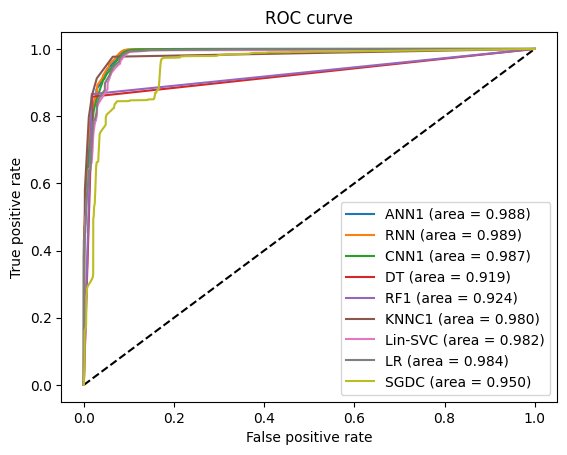

In [17]:
# ROC and AUC
# == Remember to check if correct X_columns
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier 

# test_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')] 
folder = 'SavedModels/PerPacket/'
Models = ["ANN1.keras", "RNN.pkl", 'CNN1.pkl', 'DT.pkl', "RF1.pkl", "KNNC1.pkl", "Lin-SVC.pkl","LR.pkl","SGDC.pkl"]
ModelTypes = ["TF", "TF_RNN", 'TF_CNN', 'SK_RF', "SK_RF", "SK_LR", "SK_LR","SK_LR","SK_LR"]
#Models = ["LR.pkl"]
#ModelTypes = ["SK_LR"]


#=== GRAPHING ===
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for i in range(len(Models)):
    model_name = Models[i].split('.')
    if model_name[1] == 'pkl':
        model = Model(joblib.load(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    elif model_name[1] == 'keras':
        model = Model(load_model(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    else:
        print(f'Error occured at {i} model {Models[i]} type {ModelTypes[i]} : {model_name[0]} - {model.name[1]}')
        raise Exception
        
    
    print(model_name[0])

    # try:
    y_onehot_test, y_predict = getROC(model)

    # print(y_onehot_test.shape)
    # print(y_predict.shape)
    # print(y_predict[0])
    # print(y_onehot_test.ravel().shape)

    # class_of_interest = ATTACKS_ENUM['Benign'].value
    # display = RocCurveDisplay.from_predictions(
    #     y_onehot_test.ravel(),
    #     y_predict.ravel(),
    #     name=f"{class_of_interest} vs the rest",
    #     color="darkorange",
    #     plot_chance_level=True,
    # )
    # display.ax_.set(
    #     xlabel="False Positive Rate",
    #     ylabel="True Positive Rate",
    #     title="Micro-averaged One-vs-Rest\nAttack Detection",
    # ) 


    fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_predict.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name[0]} (area = {roc_auc:.3f})')
    
    # except Exception as e:
    #     print(f"error at model {i}")
    #     print(e)


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(fname='outputs/PerPacketGraph.png')
plt.show()


 # try:
        # toDisplay = RocCurveDisplay.from_estimator(model.model, x_test, y_test, name=model_name[0])
        # toDisplay.plot()
    # except Exception as e:
        # print(f"graphing failed for {model_name[0]}")
        # print(e)
    # model.model = OneVsRestClassifier(model.model)


In [ ]:
sum_datapoints = 0
for test_set in test_sets:
    df = pd.read_csv(DATASET_DIRECTORY + test_set, index_col=None, header=0, delimiter=',')[all_columns]
    sum_datapoints+=len(df)
print(sum_datapoints)

In [ ]:
# times = [10031250000, 19765625000, 26000000000, 1750000000, 7687500000, 355734375000, 1656250000, 1656250000, 1875000000]
# predictions = 269253
# for time in times:
#     print(f"{time/predictions},")

In [62]:
class model_results:
    def __init__(self, name, accuracy, precision, f1, recall):
        self.name = name
        self.accuracy = accuracy
        self.acc_avg = sum(accuracy)/len(accuracy) * 100
        self.precision = precision
        self.prec_avg = sum(precision)/len(precision) * 100
        self.f1 = f1
        self.f1_avg = sum(f1)/len(f1) * 100
        self.recall = recall
        self.recall_avg = sum(recall)/len(recall) * 100

resultsPerPacket = []
# === PerPacket ===
resultsPerPacket.append(model_results("ANN", 
                             [0.8363423935081862, 0.8189355078707189, 0.8360923974007755], 
                             [0.8242813893762964, 0.7930755803831608, 0.8264773518966853],
                             [0.8033314280507646, 0.7704990399217961, 0.8007358074495404],
                             [0.8363423935081862, 0.8189355078707189, 0.8360923974007755]))
resultsPerPacket.append(model_results("CNN", 
                             [0.828229560448817, 0.8116027400347054, 0.8105641681981548], 
                             [0.8377076880563963, 0.7851717480546523, 0.7773409906723195],
                             [0.7769779968512212, 0.7445170728149125, 0.7449511561466423],
                             [0.828229560448817, 0.8116027400347054, 0.8105641681981548]))
resultsPerPacket.append(model_results("DT", 
                             [0.8617882255411691], 
                             [0.8564233611567722],
                             [0.8582112668335136],
                             [0.8617882255411691]))

resultsPerPacket.append(model_results("KNNC", 
                             [0.8653204722827816,0.8653204722827816,0.8653204722827816], 
                             [0.8582076734243121,0.8582076734243121,0.8582076734243121],
                             [0.8602734859584316, 0.8602734859584316,0.8602734859584316],
                             [0.8653204722827816, 0.8653204722827816, 0.8653204722827816]))

resultsPerPacket.append(model_results("Lin-SVC", 
                             [0.7990202473636532], 
                             [0.7360296695982713],
                             [0.7205289617679674],
                             [0.7990202473636532]))


resultsPerPacket.append(model_results("LR", 
                             [0.805402353019455], 
                             [0.7596829533364038],
                             [0.7355421024096104],
                             [0.805402353019455]))

resultsPerPacket.append(model_results("RF", 
                             [0.8671398830250322,0.8672330150371933,0.8671038100857423], 
                             [0.8602387055785887,0.8603159380506288,0.8601849251027491],
                             [0.8618976996130436,0.8620041671283907,0.8618578937212659],
                             [0.8671398830250322, 0.8672330150371933, 0.8671038100857423]))

resultsPerPacket.append(model_results("RNN", 
                             [0.8391164315526615], 
                             [0.8320809279562782],
                             [0.8039819651087701],
                             [0.8391164315526615]))

resultsPerPacket.append(model_results("SGDC", 
                             [0.7491903656045588], 
                             [0.7651089288249903],
                             [0.7522664614731994],
                             [0.7491903656045588]))


resultsPerFlow = []
resultsPerFlow.append(model_results("ANN", 
                             [0.8980204466835671, 0.9897758845340996, 0.9901803269794348], 
                             [0.9295431281392179, 0.9888539062611567, 0.9894651547332924],
                             [0.9042644801047449, 0.9890495496217642, 0.9895601306618789],
                             [0.8980204466835671, 0.9897758845340996, 0.9901803269794348]))

resultsPerFlow.append(model_results("CNN", 
                             [0.9587012233175093, 0.9582944598251419, 0.9828162250084888], 
                             [0.9633181124042057, 0.9641698858143064, 0.9835770658807919],
                             [0.9575811933769967, 0.9569877704039879, 0.9806759958921172],
                             [0.9587012233175093, 0.9582944598251419, 0.9828162250084888]))

resultsPerFlow.append(model_results("DT", 
                             [0.9938437128783585], 
                             [0.9938571777665077],
                             [0.9938480082668094],
                             [0.9938437128783585]))

resultsPerFlow.append(model_results("KNNC", 
                             [0.9470609790311776, 0.9470609790311776, 0.9470609790311776], 
                             [0.9459529861827173, 0.9459529861827173, 0.9459529861827173],
                             [0.9460690520641846, 0.9460690520641846, 0.9460690520641846],
                             [0.9470609790311776, 0.9470609790311776, 0.9470609790311776]))

resultsPerFlow.append(model_results("Lin-SVC", 
                             [0.8251153923038529], 
                             [0.8105785696249442],
                             [0.7725492921047848],
                             [0.8251153923038529]))

resultsPerFlow.append(model_results("LR", 
                             [0.8316742843752626], 
                             [0.8220156640220578],
                             [0.7853791074821646],
                             [0.8316742843752626]))

resultsPerFlow.append(model_results("RF", 
                             [0.991719374582272, 0.9918904550905929, 0.9919651154367906], 
                             [0.991391416107968, 0.9916237016604927, 0.9914063587149685],
                             [0.990869295834786, 0.991074670013465, 0.9911420457087886],
                             [0.991719374582272, 0.9918904550905929, 0.9919651154367906]))

resultsPerFlow.append(model_results("RNN", 
                             [0.9919436457517441], 
                             [0.9918803825902216],
                             [0.9914553675687228],
                             [0.9919436457517441]))

resultsPerFlow.append(model_results("SGDC", 
                             [0.8464756012986645], 
                             [0.8545348880290421],
                             [0.8471558640621556],
                             [0.8464756012986645]))

print("Model Name & Average Accuracy & Average Precision & Average Recall & Average f1 score\\\\")
for result in resultsPerFlow:
    print(f"{result.name} & {result.acc_avg:.2f} & {result.prec_avg:.2f} & {result.recall_avg:.2f} & {result.f1_avg:.2f}\\\\")

Model Name & Average Accuracy & Average Precision & Average Recall & Average f1 score\\
ANN & 95.93 & 96.93 & 95.93 & 96.10\\
CNN & 96.66 & 97.04 & 96.66 & 96.51\\
DT & 99.38 & 99.39 & 99.38 & 99.38\\
KNNC & 94.71 & 94.60 & 94.71 & 94.61\\
Lin-SVC & 82.51 & 81.06 & 82.51 & 77.25\\
LR & 83.17 & 82.20 & 83.17 & 78.54\\
RF & 99.19 & 99.15 & 99.19 & 99.10\\
RNN & 99.19 & 99.19 & 99.19 & 99.15\\
SGDC & 84.65 & 85.45 & 84.65 & 84.72\\


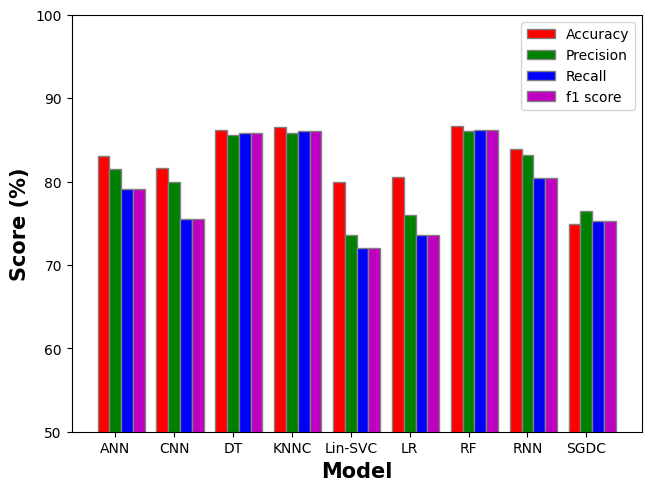

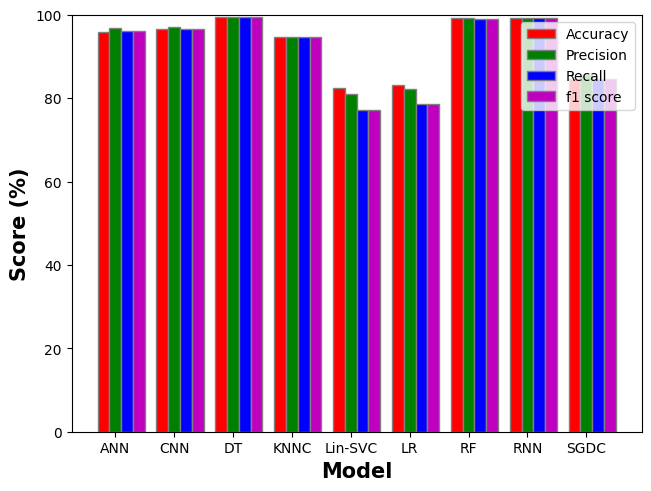

In [50]:
names = []
accuracies = []
precisions = []
recalls = []
f1s = []

width = 0.2  # the width of the bars
multiplier = 0

br1 = np.arange(len(resultsPerPacket))
br2 = [i + width for i in br1] 
br3 = [i + width for i in br2] 
br4 = [i + width for i in br3] 

fig, ax = plt.subplots(layout="constrained")

for result in resultsPerPacket:
    names.append(result.name)
    accuracies.append(result.acc_avg)
    precisions.append(result.prec_avg)
    recalls.append(result.recall_avg)
    f1s.append(result.f1_avg)

plt.bar(br1, accuracies, color ='r', width = width, 
        edgecolor ='grey', label ='Accuracy') 
plt.bar(br2, precisions, color ='g', width = width, 
        edgecolor ='grey', label ='Precision') 
plt.bar(br3, f1s, color ='b', width = width, 
        edgecolor ='grey', label ='Recall') 
plt.bar(br4, f1s, color ='m', width = width, 
        edgecolor ='grey', label ='f1 score') 

plt.xlabel('Model', fontweight ='bold', fontsize = 15) 
plt.ylabel('Score (%)', fontweight ='bold', fontsize = 15) 
plt.xticks([r + width for r in range(len(names))], 
        names)
ax.set_ylim(50, 100)
plt.legend()
plt.savefig(fname='outputs/PerPacketBarPlot3.png')
plt.show() 








names = []
accuracies = []
precisions = []
recalls = []
f1s = []

width = 0.2  # the width of the bars
multiplier = 0

br1 = np.arange(len(resultsPerFlow))
br2 = [i + width for i in br1] 
br3 = [i + width for i in br2]
br4 = [i + width for i in br3] 

fig, ax = plt.subplots(layout="constrained")

for result in resultsPerFlow:
    names.append(result.name)
    accuracies.append(result.acc_avg)
    precisions.append(result.prec_avg)
    recalls.append(result.recall_avg)
    f1s.append(result.f1_avg)

plt.bar(br1, accuracies, color ='r', width = width, 
        edgecolor ='grey', label ='Accuracy') 
plt.bar(br2, precisions, color ='g', width = width, 
        edgecolor ='grey', label ='Precision') 
plt.bar(br3, f1s, color ='b', width = width, 
        edgecolor ='grey', label ='Recall') 
plt.bar(br4, f1s, color ='m', width = width, 
        edgecolor ='grey', label ='f1 score') 

plt.xlabel('Model', fontweight ='bold', fontsize = 15) 
plt.ylabel('Score (%)', fontweight ='bold', fontsize = 15) 
plt.xticks([r + width for r in range(len(names))], 
        names)
ax.set_ylim(0, 100)
plt.legend()
plt.savefig(fname='outputs/PerFlowBarPlot3.png')
plt.show() 

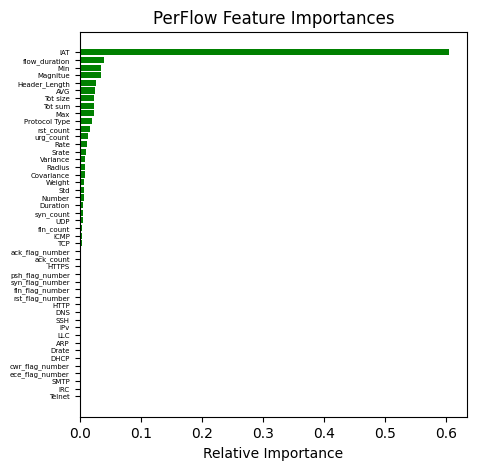

In [53]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
] #columns 0-45

# X_columns = [
#     'Header_Length', 'Protocol Type', 'Duration',
#         'fin_flag_number', 'syn_flag_number',
#        'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
#        'ece_flag_number', 'cwr_flag_number', 
#     'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
#        'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
# ] #columns 0-45

folder = "SavedModels/PerFlow/"
models = ["RF1.pkl", "RF2.pkl", "RF3.pkl", "DT.pkl"]
features = X_columns
importances = [0]*len(features)
plt.figure(figsize=(5,5))
plt.title('PerFlow Feature Importances')
for model in models:
   rf = joblib.load(folder+model)
   importances += rf.feature_importances_
for i in range(len(importances)):
   importances[i] = importances[i]/len(models)
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(fontsize=5)
plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xticks(np.arange(min(importances), max(importances)+0.01, 0.05))
plt.xlabel('Relative Importance')
# plt.savefig(fname='outputs/PerFlowDTFeatureImportance.png')
plt.show()

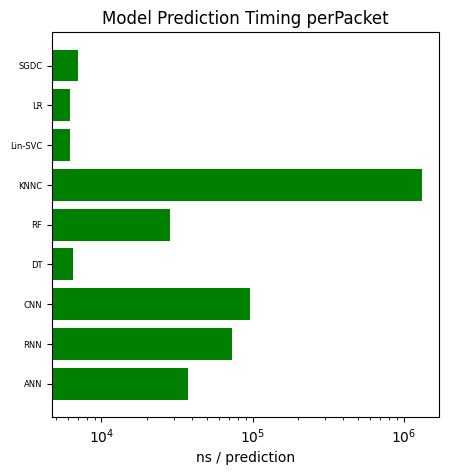

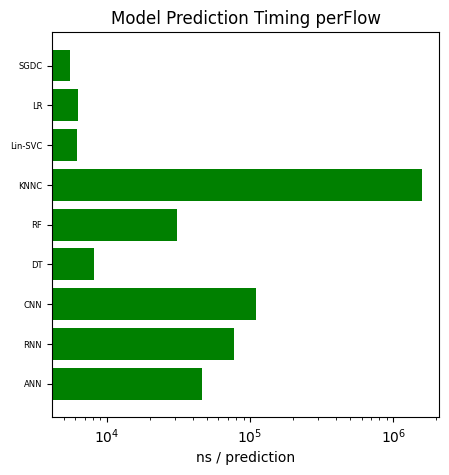

In [54]:
import matplotlib.pyplot as plt
timingsPerPacket = [37255.85230248131,
73409.11707576146,
96563.45518898583,
6499.463330027892,
28551.213914051095,
1321190.0145959377,
6151.277794490684,
6151.277794490684,
6963.71071074417] # ns/pred 

timingsPerFlow = [46116.68749973871,
                  77470.80931259223,
                  109739.42634498731,
                  8165.135888763937,
                  31027.51637730296,
                  1583709.7569846532,
                  6140.182188350481,
                  6270.824362570704,
                  5486.971317249366]

models = ["ANN", "RNN", "CNN", "DT", "RF", "KNNC", "Lin-SVC", "LR", "SGDC"]

plt.figure(figsize=(5,5))
plt.title('Model Prediction Timing perPacket')
plt.barh(range(len(timingsPerPacket)), timingsPerPacket, color='g', align='center')
plt.yticks(fontsize=6)
plt.yticks(range(len(models)), models)
plt.xscale('log')
# plt.xticks(np.arange(min(timingsPerPacket), max(timingsPerPacket), 0.05))
plt.xlabel('ns / prediction')
plt.savefig(fname='outputs/PerPacketTiming.png')
plt.show()

plt.figure(figsize=(5,5))
plt.title('Model Prediction Timing perFlow')
plt.barh(range(len(timingsPerFlow)), timingsPerFlow, color='g', align='center')
plt.yticks(fontsize=6)
plt.yticks(range(len(models)), models)
plt.xscale('log')
# plt.xticks(np.arange(min(timingsPerPacket), max(timingsPerPacket), 0.05))
plt.xlabel('ns / prediction')
plt.savefig(fname='outputs/PerFlowTiming.png')
plt.show()

In [58]:
fastest = timingsPerFlow[8]
print(fastest)
for i in range(len(models)):
    print(f"{models[i]} : {((timingsPerFlow[i]/fastest)-1) *100 }")

5486.971317249366
ANN : 740.4761904761904
RNN : 1311.904761904762
CNN : 1900.0
DT : 48.80952380952381
RF : 465.4761904761904
KNNC : 28763.095238095237
Lin-SVC : 11.904761904761907
LR : 14.28571428571428
SGDC : 0.0


In [20]:
attack_count = [0]*len(ATTACKS)
for set in tqdm(df_sets):
    df = pd.read_csv(DATASET_DIRECTORY + set, index_col=None, header=0, delimiter=',')[[Y_columns]]
    for k in df[Y_columns]:
        attack_count[ATTACKS_ENUM[dict_7classes[k]].value]+=1

for i in range(len(attack_count)):
    print(f"{ATTACKS[i]} : {attack_count[i]}")



100%|██████████| 169/169 [04:52<00:00,  1.73s/it]

DDoS : 33984560
DoS : 8090738
Mirai : 2634124
Recon : 354565
Spoofing : 486504
Benign : 1098195
Web : 24829
BruteForce : 13064


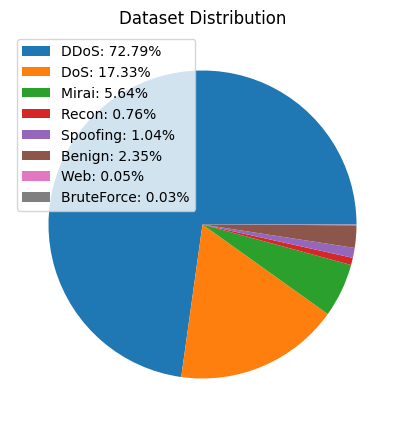

In [34]:
total = sum(attack_count)
labels = [f"{ATTACKS[i]}: {attack_count[i]*100/total :0.2f}%" for i in range(len(ATTACKS))]
plt.figure(figsize=(5,5))
plt.title('Dataset Distribution')
patches, texts = plt.pie(attack_count)
plt.legend(patches, labels, loc=2)
plt.savefig(fname='outputs/DatasetDistribution.png')
plt.show()

In [3]:
import csv
import os
import sys
import pandas
import numpy
import pandas as pd


In [4]:
class Timeframe:
    def __init__(self, start, end):
        self.start = start
        self.end = end

timeframes = []

AnnotationDir = "EncryptedAnnotation/"
annotations = [k for k in os.listdir(AnnotationDir) if k.endswith('.csv')]
for annotation in annotations:
    # print(annotation)
    df = pd.read_csv(AnnotationDir+annotation, header=None, delimiter=',')
    start_times = df[0]
    end_times = df[1]
    for i in range(len(start_times)):
        timeframe = Timeframe(start_times[i], end_times[i])
        timeframes.append(timeframe)

def isAttack(time):
    for timeframe in timeframes:
        if (time>=timeframe.start and time<=timeframe.end):
            return "Attack"
    return "Benign"

00166cab6b88.csv
0017882b9a25.csv
44650d56ccd3.csv
50c7bf005639.csv
70ee50183443.csv
74c63b29d71d.csv
d073d5018308.csv
ec1a5979f489.csv
ec1a59832811.csv
f4f5d88f0a3c.csv


In [5]:
ENCRYPTED_DIRECTORY = 'dataset/'


def split(filehandler, delimiter=',', row_limit=1000,
          output_name_template='output_%s.csv', output_path='.', keep_headers=True):
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(open(current_out_path, 'w', newline=""), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        # print(headers)
        headers.append("label")
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        row.append(isAttack(float(row[0])))
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(open(current_out_path, 'w', newline=""), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)

split(open('dataset/e18-10-24.csv', 'r'), output_name_template='dataset/e18-10-24_part-%s-encrypted.csv', row_limit=250000)


encrypted_sets = [k for k in os.listdir(ENCRYPTED_DIRECTORY) if k.endswith('encrypted.csv')] # all encrypted files
print(len(encrypted_sets))


3


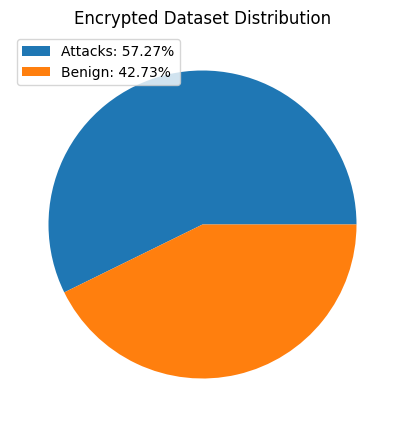

In [18]:
import matplotlib.pyplot as plt
encrypted_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('encrypted.csv')] # all encrypted files
count_attacks = 0
count_benign = 0

# df = pd.read_csv(DATASET_DIRECTORY+set, index_col=None, header=0, delimiter=',')[all_columns]
# for X_col in X_columns:
#     print(df[X_columns][1])


for set in encrypted_sets:
    df = pd.read_csv(DATASET_DIRECTORY+set, index_col=None, header=0, delimiter=',')[all_columns]
    X = df[X_columns]
    Y = df[Y_columns]
    for y in Y:
        if(y=="Attack"):
            count_attacks+=1
        elif(y=="Benign"):
            count_benign+=1
        else:
            print(f"Error, {y}")
            
both = [count_attacks, count_benign]
total = count_attacks+count_benign
labels = [f"Attacks: {count_attacks*100/total :0.2f}%", f"Benign: {count_benign*100/total :0.2f}%"]
plt.figure(figsize=(5,5))
plt.title('Encrypted Dataset Distribution')
patches, texts = plt.pie(both)
plt.legend(patches, labels, loc=2)
plt.savefig(fname='outputs/EncryptedDatasetDistribution.png')
plt.show()

In [72]:
print(total)

513264


In [71]:
test_sets = encrypted_sets
folder = 'SavedModels/PerFlow/'
# Models = ["ANN1.keras","ANN2.keras","ANN3.keras", "RNN.pkl", 'CNN1.pkl','CNN2.pkl', 'CNN3.pkl', 'DT.pkl', "RF1.pkl", "RF2.pkl","RF3.pkl", "KNNC1.pkl", "KNNC2.pkl","KNNC3.pkl", "Lin-SVC.pkl","LR.pkl","SGDC.pkl"]
# ModelTypes = ["TF", "TF", "TF", "TF_RNN", 'TF_CNN','TF_CNN','TF_CNN', 'SK_RF', "SK_RF","SK_RF","SK_RF", "SK_LR", "SK_LR", "SK_LR", "SK_LR","SK_LR","SK_LR"]

Models = ["DT.pkl"]
ModelTypes = ["SK_RF"]

for i in range(len(Models)):
    model_name = Models[i].split('.')
    if model_name[1] == 'pkl':
        model = Model(joblib.load(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    elif model_name[1] == 'keras':
        model = Model(load_model(folder+Models[i]),model_name[0], TYPES[ModelTypes[i]])
    else:
        print(f'Error occured at {i} model {Models[i]} type {ModelTypes[i]} : {model_name[0]} - {model.name[1]}')
    testModel(model, encrypted=True)

100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


test set:
0, 1
pred set:
0, 1
2024-07-04 17:46:33.899988
===== DT =====

Accuracy  : 0.5265321549923626
Precision : 0.3887940433471574
Recall : 0.5265321549923626
f1Score : 0.41242049648260953
[[264241  29689]
 [213325   6009]]


In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     # 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'loss': ['log_loss'],
#     'penalty': ['l2', 'l1'],
#     # 'penalty': ['l2'],
#     'alpha': [1e-10, 1e-9, 1e-8, 1e-7],
#     'max_iter': [1000],
#     'tol': [1e-5]
# }
# grid_search = GridSearchCV(SGDClassifier(), param_grid, scoring='accuracy', n_jobs=-1)
# print(f"Last ran on grid, with {len(training_sets)} training sets on date: {datetime.datetime.now()}")
# for train_set in tqdm(training_sets):
#     df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[all_columns]
#     x_train = scaler.transform(df[X_columns])
#     y_train = [ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns]]

#     grid_search.fit(x_train, y_train)                   
#     del df
#     del x_train
#     del y_train


In [ ]:
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# print("Best Parameters:", best_params)
# testModel(Model(best_model, "SGDC FromGrid", TYPES["SK_LR"]))
# # print("Best Model Accuracy:", best_model.score(x_test, y_test))
# # print("Best Model Classification Report:\n", classification_report(y_test, best_model.predict(X_test)))
# # print("Best Model Confusion Matrix:\n", confusion_matrix(y_test, best_model.predict(X_test)))

In [ ]:
#====For debug ===
# test_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')] 
#testModel(Model(load_model("SavedModels\\BestANN.keras"),"BestANN", TYPES['TF']))
# testModel(Model(joblib.load("SavedModels/BestRF.pkl"),"BestRF", TYPES['SK_RF']))

In [ ]:
# model = getSimpleRFModel()
# num_sample = 10
# for train_set in tqdm(training_sets):
#     df = pd.read_csv(DATASET_DIRECTORY + train_set, index_col=None, header=0, delimiter=',')[all_columns]
#     df = df[0:num_sample]
#     x_train = scaler.transform(df[X_columns])
#     y_train = [ATTACKS_ENUM[dict_7classes[k]].value for k in df[Y_columns]]
#     y_train_Cat = to_categorical(y_train, num_classes=8)

    
#     if model.type==TYPES["SK_LR"]:
#         model.model.fit(x_train, y_train)  
    
#     elif model.type==TYPES["SK_RF"]:
#         model.model.fit(x_train, y_train_Cat)  

#     elif model.type == TYPES["TF"]:
#         model.model.fit(x=x_train, 
#                     y=y_train_Cat, 
#                     epochs=epochs, 
#                     verbose=verbose,
#                     batch_size=batch_size)                   
#     del df
#     del x_train
#     del y_train
#     del y_train_Cat

In [ ]:
# # Tree Visualisation
# from sklearn.tree import export_graphviz
# import matplotlib.pyplot as plt
# from sklearn import tree
# rf = joblib.load("SavedModels/BestRF.pkl")
# for tree_in_rf in rf:
#     fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
#     # export_graphviz(tree,
#     #             feature_names=X_columns,
#     #             class_names=ATTACKS,
#     #             filled=True,
#     #             rounded=True)
#     tree.plot_tree(rf.estimators_[0],
#                 feature_names=X_columns,
#                 class_names=ATTACKS,
#                filled = True)
#     fig.savefig(f'rf_{i}.png')
#     i+=1
# for tree_in_rf in rf[:1]:
#     export_graphviz(tree_in_rf,
#                 feature_names=X_columns,
#                 class_names=ATTACKS,
#                 filled=True,
#                 rounded=True,
#                 out_file="tree.png")
#     os.system("-Tpng tree.dot -o tree.png")
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# tree.plot_tree(model.model.estimators_[0])#,
#             # feature_names=X_columns,
#             # class_names=ATTACKS,
#             # filled = True)
# fig.savefig(f'rf_{num_sample}_samples.png')



# # == Feature importance for RF and DT

# Save Models

In [ ]:
# for i in range(len(ML_Models)):
#     model = ML_Models[i]
#     if model.type==TYPES["TF"]:
#         model.model.save(f"SavedModels\\{model.name}.keras",overwrite=True)
#     elif model.type==TYPES["SK_RF"] or model.type==TYPES["SK_LR"]:
#         joblib.dump(model.model, f"SavedModels/{model.name}.pkl") 